# Th1

Files:<br>

- RNA-seq: `/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/deseq/all/individual/Th1.Sorted.72hr_vs_mmTh0.Sorted.72hr.with_genes.txt`
- ATAC-seq: `/data/reddylab/Revathy/collabs/Keith/Th1/data/atac_seq/deseq/Th1.96hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.with_closest_gene.txt`
- STARR-seq: `/data/reddylab/Revathy/collabs/Keith/Th1/data/starr_seq/220407_Th1vsallPooledASTARR_allPooled_deseq2_q0.01.bed`

In [1]:
!wc -l /data/reddylab/Revathy/collabs/Keith/Th1/data/starr_seq/220407_Th1vsallPooledASTARR_allPooled_deseq2_q0.01.bed

2740 /data/reddylab/Revathy/collabs/Keith/Th1/data/starr_seq/220407_Th1vsallPooledASTARR_allPooled_deseq2_q0.01.bed


In [2]:
!head /data/reddylab/Revathy/collabs/Keith/Th1/data/starr_seq/220407_Th1vsallPooledASTARR_allPooled_deseq2_q0.01.bed

chr1	171064553	171065376	2.98313936654232	5.92619147668324e-144	chr1_171064553_171065376
chr1	24612411	24613664	2.90871622425359	2.09885525982457e-184	chr1_24612411_24613664
chr17	6978745	6979746	2.4900088088451	1.00140765740599e-111	chr17_6978745_6979746
chr17	8147478	8147959	2.30096651305992	1.01604014359822e-85	chr17_8147478_8147959
chr8	20424335	20424751	2.25098968887044	3.18268298031042e-83	chr8_20424335_20424751
chr8	20550138	20550875	1.98546109739457	4.36689527600234e-71	chr8_20550138_20550875
chr13	62558365	62558943	1.94108015580134	5.74315417934226e-69	chr13_62558365_62558943
chr2	177840327	177840691	1.91205204370364	8.37439603275712e-62	chr2_177840327_177840691
chr13	62382579	62383568	1.8868590669046	4.51074607929679e-74	chr13_62382579_62383568
chr4	88763225	88764422	1.86902837853148	4.91917777887449e-60	chr4_88763225_88764422


In [3]:
!wc -l /data/reddylab/Revathy/collabs/Keith/Th1/data/atac_seq/deseq/Th1.96hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.with_closest_gene.txt

79831 /data/reddylab/Revathy/collabs/Keith/Th1/data/atac_seq/deseq/Th1.96hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.with_closest_gene.txt


## Methodolgy

1. Find the ATACseq peaks with genes in the 100kb region.
2. Intersect this with the RNA DE genes to obtain ATAC peaks with DE genes in the 100kb region
3. Intersect the ATAC peaks produced from the above step with ASTARR peaks 
4. To get distance between the union peaks and the genes: 
  - retrieve the genenames from the intersection table above
  - create the gene annotation bed file for these genes
  - use bedtools closest to find the overlapping regions and the distance between them
  - merge this back to the main intersection table

In [30]:
import pandas as pd

RNA = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/deseq/all/individual/Th1.Sorted.72hr_vs_mmTh0.Sorted.72hr.with_genes.txt', sep='\t')
RNA_filtered = RNA[RNA['padj']<0.05]
RNA_filtered = RNA_filtered[RNA_filtered['GeneType']=='protein_coding']
RNA_filtered.to_csv('/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/deseq/all/individual/Th1.Sorted.72hr_vs_mmTh0.Sorted.72hr.padj0.05.with_genes.txt', sep='\t', index=False)

ATAC = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th1/data/atac_seq/deseq/Th1.96hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.with_closest_gene.txt', sep='\t')
ATAC_filtered = ATAC[ATAC['padj']<0.05].rename(columns={'Unnamed: 0':'chr_start_end'})
ATAC_filtered[['chr','start','end']] = ATAC_filtered.chr_start_end.str.split("_",expand=True)
ATAC_filtered[['chr','start','end','log2FoldChange','padj','genes','distance']].to_csv('/data/reddylab/Revathy/collabs/Keith/Th1/data/atac_seq/deseq/Th1.96hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.padj0.05.with_closest_gene.bed', sep='\t', header=None, index=False)


ASTARR = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th1/data/starr_seq/220407_Th1vsallPooledASTARR_allPooled_deseq2_q0.01.bed', sep='\t', 
                     names=['chr','start','end','ASTARR_log2FC','ASTARR_padj','chr_start_end'])

print(RNA_filtered.shape)
print(ATAC_filtered.shape)
print(ASTARR.shape)


(7072, 8)
(43880, 11)
(2740, 6)
43880


#### 1. ATAC peaks with genes in the 100kb region

In [5]:
%%bash 
module load bedtools2
bedtools window -a /data/reddylab/Revathy/collabs/Keith/Th1/data/atac_seq/deseq/Th1.96hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.padj0.05.with_closest_gene.bed \
-b /data/reddylab/Revathy/collabs/Keith/data/annotation_files/gencode.vM19.basic.annotation.TSS.bed \
-w 100000 > /data/reddylab/Revathy/collabs/Keith/Th1/data/integration/Th1_ATAC_sig_hits_100kb_genes.txt

In [6]:
!wc -l /data/reddylab/Revathy/collabs/Keith/Th1/data/integration/Th1_ATAC_sig_hits_100kb_genes.txt

125315 /data/reddylab/Revathy/collabs/Keith/Th1/data/integration/Th1_ATAC_sig_hits_100kb_genes.txt


In [7]:
!head /data/reddylab/Revathy/collabs/Keith/Th1/data/integration/Th1_ATAC_sig_hits_100kb_genes.txt

chr10	100015482	100016662	-1.17551616214688	6.7186456886707e-07	Kitl	0	chr10	100015628	100015629	ENSMUSG00000019966.18	.	+	Kitl	protein_coding
chr10	100449517	100450249	2.75986607958417	4.18511712641705e-11	Tmtc3	0	chr10	100351091	100351092	ENSMUSG00000112856.1	.	+	Gm4305	protein_coding
chr10	100449517	100450249	2.75986607958417	4.18511712641705e-11	Tmtc3	0	chr10	100361336	100361337	ENSMUSG00000096744.1	.	+	Gm4307	protein_coding
chr10	100449517	100450249	2.75986607958417	4.18511712641705e-11	Tmtc3	0	chr10	100382559	100382560	ENSMUSG00000096640.3	.	-	Gm4312	protein_coding
chr10	100449517	100450249	2.75986607958417	4.18511712641705e-11	Tmtc3	0	chr10	100487349	100487350	ENSMUSG00000036676.14	.	-	Tmtc3	protein_coding
chr10	100449517	100450249	2.75986607958417	4.18511712641705e-11	Tmtc3	0	chr10	100487556	100487557	ENSMUSG00000019971.10	.	+	Cep290	protein_coding
chr10	100486658	100488168	-0.344230312715036	0.0031353907931958107	Cep290,Tmtc3	0	chr10	100487349	100487350	ENSMUSG00000036676.14	.

#### 2. Intersect this with the RNA DE genes to obtain ATAC peaks with DE genes in the 100kb region

In [28]:
Th1_ATAC_sig_hits_100kb_genes = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th1/data/integration/Th1_ATAC_sig_hits_100kb_genes.txt', sep='\t',
                                            names=['chr','start','end','ATAC_log2FC','ATAC_padj','gene','distance','gene_chr','gene_start','gene_end','ENSID','score','strand','GeneName','GeneType'])
Th1_ATAC_sig_hits_100kb_genes['chr_start_end'] = Th1_ATAC_sig_hits_100kb_genes['chr']+'_'+Th1_ATAC_sig_hits_100kb_genes['start'].astype('str')+'_'+Th1_ATAC_sig_hits_100kb_genes['end'].astype('str')
Th1_ATAC_sig_hits_100kb_DE_genes = Th1_ATAC_sig_hits_100kb_genes.merge(RNA_filtered, on='GeneName', how='inner')
Th1_ATAC_sig_hits_100kb_DE_genes = Th1_ATAC_sig_hits_100kb_DE_genes.rename(columns={'log2FoldChange':'RNA_log2FC',
                                                                                    'padj':'RNA_padj'})
Th1_ATAC_sig_hits_100kb_DE_genes['chr_start_end'] = Th1_ATAC_sig_hits_100kb_DE_genes['chr']+'_'+Th1_ATAC_sig_hits_100kb_DE_genes['start'].astype('str')+'_'+Th1_ATAC_sig_hits_100kb_DE_genes['end'].astype('str')
Th1_ATAC_sig_hits_100kb_DE_genes[['chr','start','end','ATAC_log2FC','ATAC_padj','RNA_log2FC','RNA_padj','GeneName','distance','chr_start_end']].to_csv('/data/reddylab/Revathy/collabs/Keith/Th1/data/integration/Th1_ATAC_sig_hits_100kb_DE_genes.bed', sep='\t', header=None, index=False)
print(len(Th1_ATAC_sig_hits_100kb_DE_genes.chr_start_end.unique()))
print(len(Th1_ATAC_sig_hits_100kb_genes.chr_start_end.unique()))



28880
36599


In [10]:
Th1_ATAC_sig_hits_100kb_DE_genes['GeneType_x'].unique()

array(['protein_coding'], dtype=object)

In [26]:
%%bash 
module load bedtools2
bedtools intersect \
-a /data/reddylab/Revathy/collabs/Keith/Th1/data/starr_seq/220407_Th1vsallPooledASTARR_allPooled_deseq2_q0.01.bed \
-b /data/reddylab/Revathy/collabs/Keith/Th1/data/integration/Th1_ATAC_sig_hits_100kb_DE_genes.bed \
-wa \
-wb \
> /data/reddylab/Revathy/collabs/Keith/Th1/data/integration/Th1_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.txt

***** WARNING: File /data/reddylab/Revathy/collabs/Keith/Th1/data/starr_seq/220407_Th1vsallPooledASTARR_allPooled_deseq2_q0.01.bed has inconsistent naming convention for record:
JH584304.1	39920	40649	1.14162854548613	4.30137917484541e-27	JH584304.1_39920_40649

***** WARNING: File /data/reddylab/Revathy/collabs/Keith/Th1/data/starr_seq/220407_Th1vsallPooledASTARR_allPooled_deseq2_q0.01.bed has inconsistent naming convention for record:
JH584304.1	39920	40649	1.14162854548613	4.30137917484541e-27	JH584304.1_39920_40649



In [28]:
!head /data/reddylab/Revathy/collabs/Keith/Th1/data/integration/Th1_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.txt

chr1	24612411	24613664	2.90871622425359	2.09885525982457e-184	chr1_24612411_24613664	chr1	24612515	24613579	7.04812472237134	4.80739749495263e-26	0.394607335992655	1.97445952936064e-05	Lmbrd1	0	chr1_24612515_24613579
chr15	74998637	75000039	1.6895569971175	8.19827319825988e-62	chr15_74998637_75000039	chr15	74998637	74999279	1.62501916033743	3.90259207845407e-07	-0.224563245967983	0.00214985482960684	Ly6e	-607	chr15_74998637_74999279
chr15	74998637	75000039	1.6895569971175	8.19827319825988e-62	chr15_74998637_75000039	chr15	74998637	74999279	1.62501916033743	3.90259207845407e-07	8.37722668074661	2.693394113299248e-126	Ly6a	-607	chr15_74998637_74999279
chr4	41773581	41775023	1.63851073629432	3.91976336765061e-73	chr4_41773581_41775023	chr4	41773581	41775023	1.57828178251125	5.117375367802e-15	-0.332884413737997	0.0398614677537087	Il11ra1	0	chr4_41773581_41775023
chr4	41773581	41775023	1.63851073629432	3.91976336765061e-73	chr4_41773581_41775023	chr4	41773581	41775023	1.57828178251125	5.11

In [32]:
Th1_ATAC_100kb_RNA_DE_genes_ASTARR_intersected = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th1/data/integration/Th1_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.txt', sep='\t',
                                                             names=['ASTARR_chr','ASTARR_start','ATSARR_end','ASTARR_log2FC','ASTARR_padj','ASTARR_chr_start_end',
                                                                    'chr','start','end','ATAC_log2FC','ATAC_padj','RNA_log2FC','RNA_padj','GeneName','distance','chr_start_end'])
Th1_ATAC_100kb_RNA_DE_genes_ASTARR_intersected = Th1_ATAC_100kb_RNA_DE_genes_ASTARR_intersected[['chr','start','end','ATAC_log2FC','ATAC_padj','ASTARR_log2FC','ASTARR_padj','RNA_log2FC','RNA_padj','GeneName','chr_start_end','distance']]

In [38]:
Th1_ATAC_100kb_RNA_DE_genes_ASTARR_intersected

,chr,start,end,ATAC_log2FC,ATAC_padj,ASTARR_log2FC,ASTARR_padj,RNA_log2FC,RNA_padj,GeneName,chr_start_end,distance
0,chr1,24612515,24613579,7.048125,4.807397e-26,2.908716,2.098855e-184,0.394607,1.974460e-05,Lmbrd1,chr1_24612515_24613579,0
1,chr15,74998637,74999279,1.625019,3.902592e-07,1.689557,8.198273e-62,-0.224563,2.149855e-03,Ly6e,chr15_74998637_74999279,-607
2,chr15,74998637,74999279,1.625019,3.902592e-07,1.689557,8.198273e-62,8.377227,2.693394e-126,Ly6a,chr15_74998637_74999279,-607
3,chr4,41773581,41775023,1.578282,5.117375e-15,1.638511,3.919763e-73,-0.332884,3.986147e-02,Il11ra1,chr4_41773581_41775023,0
4,chr4,41773581,41775023,1.578282,5.117375e-15,1.638511,3.919763e-73,-0.409173,3.011676e-04,Rpp25l,chr4_41773581_41775023,0
5,chr4,41773581,41775023,1.578282,5.117375e-15,1.638511,3.919763e-73,-0.442818,1.054292e-07,Sigmar1,chr4_41773581_41775023,0
6,chr4,41773581,41775023,1.578282,5.117375e-15,1.638511,3.919763e-73,-0.770193,8.125976e-11,Galt,chr4_41773581_41775023,0
7,chr18,12972085,12974583,0.341725,1.267813e-03,1.293119,1.510051e-37,0.256334,3.542715e-02,Impact,chr18_12972085_12974583,0
8,chr1,155173098,155174327,1.523642,4.343076e-09,1.150586,8.005993e-26,-0.923536,9.080188e-104,Stx6,chr1_155173098_155174327,0
9,chr6,124630704,124631754,-0.810923,9.186454e-04,1.103041,7.834690e-32,-0.331035,1.747196e-05,Phb2,chr6_124630704_124631754,0


In [34]:
len(Th1_ATAC_100kb_RNA_DE_genes_ASTARR_intersected['chr_start_end'].unique())

694

In [44]:
Th1_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.sort_values('RNA_log2FC', ascending=False)

,chr,start,end,ATAC_log2FC,ATAC_padj,ASTARR_log2FC,ASTARR_padj,RNA_log2FC,RNA_padj,GeneName,chr_start_end,distance
2,chr15,74998637,74999279,1.625019,3.902592e-07,1.689557,8.198273e-62,8.377227,2.693394e-126,Ly6a,chr15_74998637_74999279,-607
1229,chr13,51845279,51849760,0.970241,4.147154e-52,0.230867,2.396551e-03,6.788005,1.446643e-278,Gadd45g,chr13_51845279_51849760,0
336,chr18,60375095,60376512,2.337453,3.568458e-10,0.480300,8.239864e-04,5.047164,4.386175e-38,Iigp1,chr18_60375095_60376512,0
192,chr11,117965351,117965994,0.715401,4.111317e-08,0.554620,1.339424e-09,4.900250,4.074599e-126,Socs3,chr11_117965351_117965994,85
61,chr11,48914111,48915025,1.961052,4.372218e-09,0.703772,5.607295e-07,3.943397,1.698009e-26,Tgtp1,chr11_48914111_48915025,0
98,chr11,48933285,48933977,1.292801,1.876730e-04,0.651204,9.383283e-08,3.943397,1.698009e-26,Tgtp1,chr11_48933285_48933977,0
706,chr8,120735751,120736945,0.221642,2.695682e-02,0.393247,4.107699e-04,3.617959,1.240383e-160,Irf8,chr8_120735751_120736945,0
1202,chr1,133815584,133816972,0.785661,3.162649e-17,0.252327,4.131687e-03,3.312335,9.881470e-152,Atp2b4,chr1_133815584_133816972,12556
1361,chr5,139324131,139326373,0.244442,1.307254e-02,-0.373581,2.708392e-03,3.003176,3.973051e-31,Gpr146,chr5_139324131_139326373,0
1044,chr8,14985151,14986883,1.196121,2.274779e-48,0.317422,4.379979e-03,2.940387,1.007801e-54,Arhgef10,chr8_14985151_14986883,0


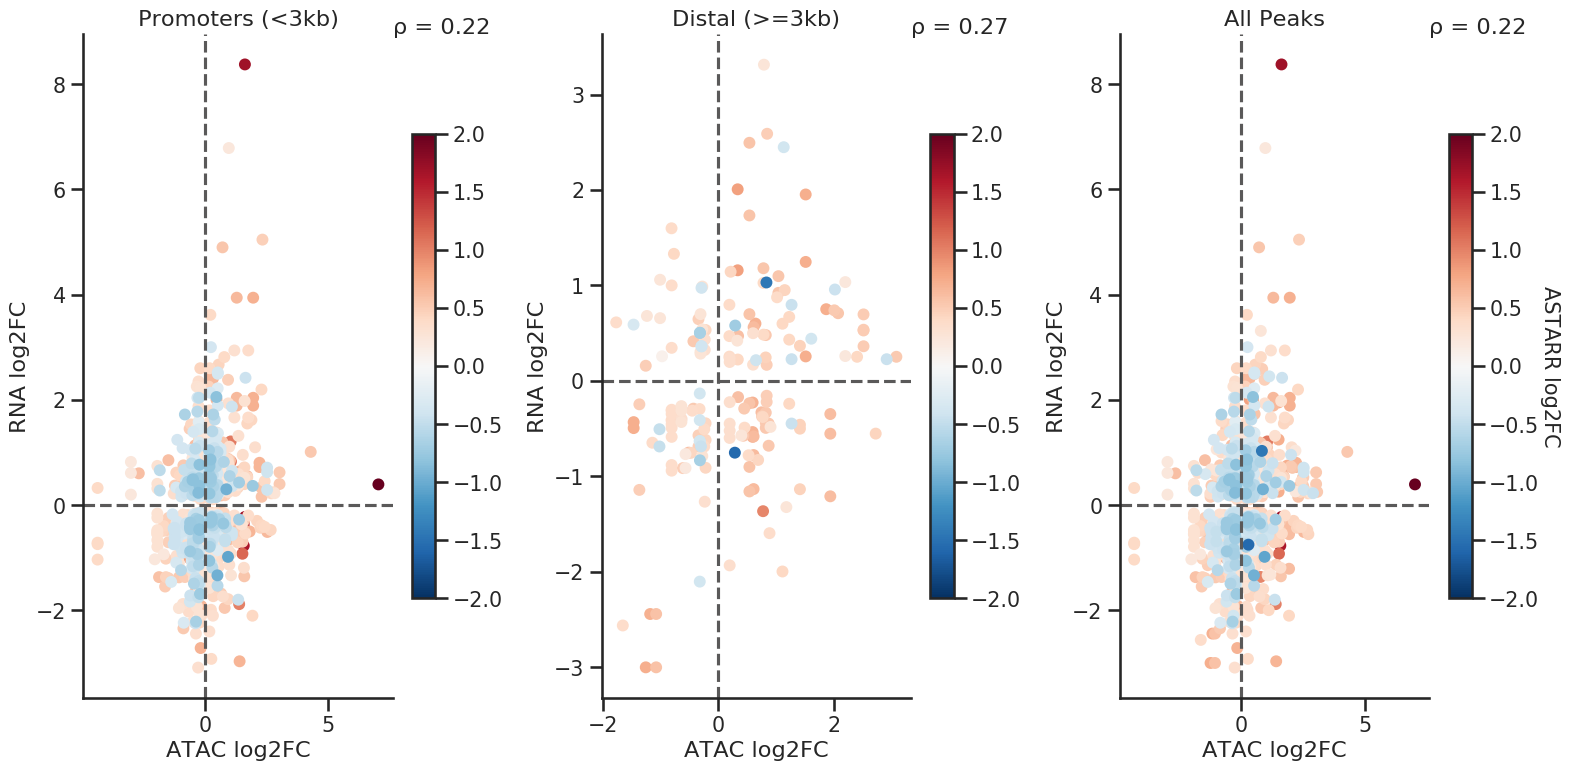

In [37]:
### Scatterplot for promoter(<3kb), distal(>=3kb) and all regions for ATACseq vs ASTARRseq

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns
import numpy as np
%matplotlib inline

from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt 

def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = "\u03C1" # u'\u03C1'
    ax.annotate('%s = %.2f' % (rho, r), xy=(1, 1), xycoords=ax.transAxes)
    
#plt.rcParams['pdf.fonttype'] = 42
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("talk", font_scale=0.9)
plt.rcParams.update({'figure.figsize':(16,8), 'figure.dpi':100})

fig, ax = plt.subplots(1, 3)

ax1 = ax.flatten()[0]
points = ax1.scatter(
    Th1_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.loc[np.abs(Th1_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.distance)<3000, 'ATAC_log2FC'], 
    Th1_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.loc[np.abs(Th1_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.distance)<3000, 'RNA_log2FC'],
    c=Th1_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.loc[np.abs(Th1_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.distance)<3000, 'ASTARR_log2FC'],
    cmap='RdBu_r', marker='o', s=50, label='All hits')

# for x, y, t in zip(
#     Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.loc[np.abs(Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.distance)<3000, 'ATAC_log2FC'],
#     Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.loc[np.abs(Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.distance)<3000, 'RNA_log2FC'], 
#     Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.loc[np.abs(Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.distance)<3000, 'GeneName']) :
#     ax1.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left', textcoords='offset points', fontsize=15)

# ax1.scatter(
#     Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.loc[np.abs(Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.distance)<3000, 'ATAC_log2FC'], 
#     Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.loc[np.abs(Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.distance)<3000, 'RNA_log2FC'],
#     c=Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.loc[np.abs(Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.distance)<3000, 'ASTARR_log2FC'],
#     cmap='RdBu_r', marker='o', s=50)

corrfunc(
    Th1_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.loc[np.abs(Th1_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.distance)<3000, 'ATAC_log2FC'], 
    Th1_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.loc[np.abs(Th1_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.distance)<3000, 'RNA_log2FC'],
    ax=ax1, method='spearman')

ax1.set_xlim(ax1.get_xlim())
ax1.set_ylim(ax1.get_ylim())
ax1.vlines(0, ax1.get_ylim()[0], ax1.get_ylim()[1], color='#5A5959', linestyle='--')
ax1.hlines(0, ax1.get_xlim()[0], ax1.get_xlim()[1], color='#5A5959', linestyle='--')
ax1.set_xlabel('ATAC log2FC')
ax1.set_ylabel('RNA log2FC')
ax1.set_title('Promoters (<3kb)')

cbar = fig.colorbar(points, shrink=0.7, ax=ax1)
#cbar.set_label('ASTARR log2FoldChange', rotation=270, labelpad=15, fontsize=15)
cbar.mappable.set_clim(-2,2)

ax2 = ax.flatten()[1]
points = ax2.scatter(
    Th1_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.loc[np.abs(Th1_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.distance)>=3000, 'ATAC_log2FC'], 
    Th1_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.loc[np.abs(Th1_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.distance)>=3000, 'RNA_log2FC'],
    c=Th1_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.loc[np.abs(Th1_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.distance)>=3000, 'ASTARR_log2FC'],
    cmap='RdBu_r', marker='o', s=50, label='All hits')

# for x, y, t in zip(
#     Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.loc[np.abs(Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.distance)>=3000, 'ATAC_log2FC'],
#     Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.loc[np.abs(Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.distance)>=3000, 'RNA_log2FC'], 
#     Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.loc[np.abs(Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.distance)>=3000, 'GeneName']) :
#     ax2.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left', textcoords='offset points', fontsize=15)
    
# ax2.scatter(
#     Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.loc[np.abs(Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.distance)>=3000, 'ATAC_log2FC'], 
#     Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.loc[np.abs(Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.distance)>=3000, 'RNA_log2FC'],
#     c=Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.loc[np.abs(Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.distance)>=3000, 'ASTARR_log2FC'],
#     cmap='RdBu_r', marker='o', s=50)

corrfunc(
    Th1_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.loc[np.abs(Th1_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.distance)>=3000, 'ATAC_log2FC'], 
    Th1_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.loc[np.abs(Th1_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.distance)>=3000, 'RNA_log2FC'],
    ax=ax2, method='spearman')

ax2.set_xlim(ax2.get_xlim())
ax2.set_ylim(ax2.get_ylim())
ax2.vlines(0, ax2.get_ylim()[0], ax2.get_ylim()[1], color='#5A5959', linestyle='--')
ax2.hlines(0, ax2.get_xlim()[0], ax2.get_xlim()[1], color='#5A5959', linestyle='--')
ax2.set_xlabel('ATAC log2FC')
ax2.set_ylabel('RNA log2FC')
ax2.set_title('Distal (>=3kb)')

cbar = fig.colorbar(points, shrink=0.7, ax=ax2)
#cbar.set_label('ASTARR log2FoldChange', rotation=270, labelpad=15, fontsize=15)
cbar.mappable.set_clim(-2,2)

ax3 = ax.flatten()[2]
points = ax3.scatter(
    Th1_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.loc[:, 'ATAC_log2FC'], 
    Th1_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.loc[:, 'RNA_log2FC'],
    c=Th1_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.loc[:, 'ASTARR_log2FC'],
    cmap='RdBu_r', marker='o', s=50, label='All hits')

# for x, y, t in zip(
#     Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.loc[:, 'ATAC_log2FC'],
#     Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.loc[:, 'RNA_log2FC'], 
#     Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.loc[:, 'GeneName']) :
#     ax3.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left', textcoords='offset points', fontsize=15)
    
# ax3.scatter(
#     Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.loc[:, 'ATAC_log2FC'], 
#     Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.loc[:, 'RNA_log2FC'],
#     c=Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.loc[:, 'ASTARR_log2FC'],
#     cmap='RdBu_r', marker='o', s=50)

corrfunc(
    Th1_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.loc[:, 'ATAC_log2FC'], 
    Th1_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.loc[:, 'RNA_log2FC'],
    ax=ax3, method='spearman')

ax3.set_xlim(ax3.get_xlim())
ax3.set_ylim(ax3.get_ylim())
ax3.vlines(0, ax3.get_ylim()[0], ax3.get_ylim()[1], color='#5A5959', linestyle='--')
ax3.hlines(0, ax3.get_xlim()[0], ax3.get_xlim()[1], color='#5A5959', linestyle='--')
ax3.set_xlabel('ATAC log2FC')
ax3.set_ylabel('RNA log2FC')
ax3.set_title('All Peaks')

cbar = fig.colorbar(points, shrink=0.7, ax=ax3)
cbar.set_label('ASTARR log2FC', rotation=270, labelpad=15, fontsize=15)
cbar.mappable.set_clim(-2,2)

sns.despine(fig,ax)
plt.tight_layout()
# plt.savefig('/data/reddylab/Revathy/collabs/Keith/data/integrative/plots/Th17_ATAC_100kb_RNA_DE_genes_ASTARR_distance_filtered_coordinate_plots_without_annotation.pdf')
plt.show()

# Th2

In [45]:
!wc -l /data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/deseq/all/individual/Th2.Sorted.72hr_vs_mmTh0.Sorted.72hr.with_genes.txt

10791 /data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/deseq/all/individual/Th2.Sorted.72hr_vs_mmTh0.Sorted.72hr.with_genes.txt


In [49]:
!wc -l /data/reddylab/Revathy/collabs/Keith/Th2/data/atac_seq/deseq/Th2.96hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.with_closest_gene.txt

74159 /data/reddylab/Revathy/collabs/Keith/Th2/data/atac_seq/deseq/Th2.96hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.with_closest_gene.txt


In [20]:
import pandas as pd

RNA = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/deseq/all/individual/Th2.Sorted.72hr_vs_mmTh0.Sorted.72hr.with_genes.txt', sep='\t')
RNA_filtered = RNA[RNA['padj']<0.05]
RNA_filtered = RNA_filtered[RNA_filtered['GeneType']=='protein_coding']
RNA_filtered.to_csv('/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/deseq/all/individual/Th2.Sorted.72hr_vs_mmTh0.Sorted.72hr.padj0.05.with_genes.txt', sep='\t', index=False)

ATAC = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th2/data/atac_seq/deseq/Th2.96hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.with_closest_gene.txt', sep='\t')
ATAC_filtered = ATAC[ATAC['padj']<0.05].rename(columns={'Unnamed: 0':'chr_start_end'})
ATAC_filtered[['chr','start','end']] = ATAC_filtered.chr_start_end.str.split("_",expand=True)
ATAC_filtered[['chr','start','end','log2FoldChange','padj','genes','distance']].to_csv('/data/reddylab/Revathy/collabs/Keith/Th2/data/atac_seq/deseq/Th2.96hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.padj0.05.with_closest_gene.bed', sep='\t', header=None, index=False)


ASTARR = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th2/data/starr_seq/220407_Th2vsallPooledASTARR_allPooled_deseq2_q0.01.bed', sep='\t', 
                     names=['chr','start','end','ASTARR_log2FC','ASTARR_padj','chr_start_end'])
# ASTARR[ASTARR['ASTARR_padj']<0.05]
RNA_filtered

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000033845.13,4435.993957,0.421907,0.057189,1.181573e-13,3.332247e-13,Mrpl15,protein_coding
2,ENSMUSG00000033813.15,3312.137001,0.779124,0.055518,2.990569e-45,2.891419e-44,Tcea1,protein_coding
3,ENSMUSG00000033793.12,2843.654378,0.844824,0.058724,1.521596e-47,1.569601e-46,Atp6v1h,protein_coding
4,ENSMUSG00000025907.14,2728.919159,0.486371,0.071101,5.167714e-12,1.330779e-11,Rb1cc1,protein_coding
6,ENSMUSG00000051285.17,1422.263412,0.911236,0.090330,1.127539e-24,5.192550e-24,Pcmtd1,protein_coding
8,ENSMUSG00000061024.8,6638.188447,-0.312209,0.073225,1.690153e-05,2.946163e-05,Rrs1,protein_coding
14,ENSMUSG00000056763.16,1615.789862,0.656503,0.087263,2.371675e-14,6.914449e-14,Cspp1,protein_coding
16,ENSMUSG00000005886.14,12410.618602,-1.057664,0.059896,7.845239e-71,1.492948e-69,Ncoa2,protein_coding
17,ENSMUSG00000025935.10,7552.910040,0.769651,0.059963,3.303878e-38,2.577646e-37,Tram1,protein_coding
18,ENSMUSG00000025937.6,2380.038850,1.372378,0.068070,3.159137e-92,9.656398e-91,Lactb2,protein_coding


In [14]:
%%bash 
module load bedtools2
bedtools window -a /data/reddylab/Revathy/collabs/Keith/Th2/data/atac_seq/deseq/Th2.96hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.padj0.05.with_closest_gene.bed \
-b /data/reddylab/Revathy/collabs/Keith/data/annotation_files/gencode.vM19.basic.annotation.TSS.bed \
-w 100000 > /data/reddylab/Revathy/collabs/Keith/Th2/data/integration/Th2_ATAC_sig_hits_100kb_genes.txt

In [15]:
!wc -l /data/reddylab/Revathy/collabs/Keith/Th2/data/integration/Th2_ATAC_sig_hits_100kb_genes.txt

!head /data/reddylab/Revathy/collabs/Keith/Th2/data/integration/Th2_ATAC_sig_hits_100kb_genes.txt

187743 /data/reddylab/Revathy/collabs/Keith/Th2/data/integration/Th2_ATAC_sig_hits_100kb_genes.txt
chr10	100015482	100016662	-1.54159130304845	1.46339407301481e-06	Kitl	0	chr10	100015628	100015629	ENSMUSG00000019966.18	.	+	Kitl	protein_coding
chr10	100486729	100488100	-1.43369237999468	2.2733178761116298e-14	Cep290,Tmtc3	0	chr10	100487349	100487350	ENSMUSG00000036676.14	.	-	Tmtc3	protein_coding
chr10	100486729	100488100	-1.43369237999468	2.2733178761116298e-14	Cep290,Tmtc3	0	chr10	100487556	100487557	ENSMUSG00000019971.10	.	+	Cep290	protein_coding
chr10	100542826	100543855	-0.937443105475332	1.73964938777509e-06	Cep290	0	chr10	100487349	100487350	ENSMUSG00000036676.14	.	-	Tmtc3	protein_coding
chr10	100542826	100543855	-0.937443105475332	1.73964938777509e-06	Cep290	0	chr10	100487556	100487557	ENSMUSG00000019971.10	.	+	Cep290	protein_coding
chr10	100542826	100543855	-0.937443105475332	1.73964938777509e-06	Cep290	0	chr10	100589394	100589395	ENSMUSG00000046567.10	.	-	4930430F08Rik	protein_

In [21]:
Th2_ATAC_sig_hits_100kb_genes = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th2/data/integration/Th2_ATAC_sig_hits_100kb_genes.txt', sep='\t',
                                            names=['chr','start','end','ATAC_log2FC','ATAC_padj','gene','distance','gene_chr','gene_start','gene_end','ENSID','score','strand','GeneName','GeneType'])
Th2_ATAC_sig_hits_100kb_DE_genes = Th2_ATAC_sig_hits_100kb_genes.merge(RNA_filtered, on='GeneName', how='inner')

Th2_ATAC_sig_hits_100kb_DE_genes = Th2_ATAC_sig_hits_100kb_DE_genes.rename(columns={'log2FoldChange':'RNA_log2FC',
                                                                                    'padj':'RNA_padj'})
Th2_ATAC_sig_hits_100kb_DE_genes['chr_start_end'] = Th2_ATAC_sig_hits_100kb_DE_genes['chr']+'_'+Th2_ATAC_sig_hits_100kb_DE_genes['start'].astype('str')+'_'+Th2_ATAC_sig_hits_100kb_DE_genes['end'].astype('str')
Th2_ATAC_sig_hits_100kb_DE_genes[['chr','start','end','ATAC_log2FC','ATAC_padj','RNA_log2FC','RNA_padj','GeneName','distance','chr_start_end']].to_csv('/data/reddylab/Revathy/collabs/Keith/Th2/data/integration/Th2_ATAC_sig_hits_100kb_DE_genes.bed', sep='\t', header=None, index=False)
len(Th2_ATAC_sig_hits_100kb_DE_genes.chr_start_end.unique())


38902

In [22]:
Th2_ATAC_sig_hits_100kb_DE_genes

,chr,start,end,ATAC_log2FC,ATAC_padj,gene,distance,gene_chr,gene_start,gene_end,...,GeneName,GeneType_x,Unnamed: 0,baseMean,RNA_log2FC,lfcSE,pvalue,RNA_padj,GeneType_y,chr_start_end
0,chr10,100486729,100488100,-1.433692,2.273318e-14,"Cep290,Tmtc3",0,chr10,100487556,100487557,...,Cep290,protein_coding,ENSMUSG00000019971.10,575.010846,-0.369366,0.113269,8.586941e-04,1.297662e-03,protein_coding,chr10_100486729_100488100
1,chr10,100542826,100543855,-0.937443,1.739649e-06,Cep290,0,chr10,100487556,100487557,...,Cep290,protein_coding,ENSMUSG00000019971.10,575.010846,-0.369366,0.113269,8.586941e-04,1.297662e-03,protein_coding,chr10_100542826_100543855
2,chr10,100566978,100567905,-1.188418,6.971269e-03,Cep290,0,chr10,100487556,100487557,...,Cep290,protein_coding,ENSMUSG00000019971.10,575.010846,-0.369366,0.113269,8.586941e-04,1.297662e-03,protein_coding,chr10_100566978_100567905
3,chr10,105523427,105523916,-1.348565,1.016160e-02,Tmtc2,0,chr10,105574434,105574435,...,Tmtc2,protein_coding,ENSMUSG00000036019.8,172.337565,0.658733,0.191909,2.413426e-04,3.845373e-04,protein_coding,chr10_105523427_105523916
4,chr10,105535649,105536079,-1.859391,1.201414e-03,Tmtc2,0,chr10,105574434,105574435,...,Tmtc2,protein_coding,ENSMUSG00000036019.8,172.337565,0.658733,0.191909,2.413426e-04,3.845373e-04,protein_coding,chr10_105535649_105536079
5,chr10,105572834,105573482,-1.271811,1.086267e-09,Tmtc2,0,chr10,105574434,105574435,...,Tmtc2,protein_coding,ENSMUSG00000036019.8,172.337565,0.658733,0.191909,2.413426e-04,3.845373e-04,protein_coding,chr10_105572834_105573482
6,chr10,105573788,105575540,-1.522586,9.481495e-25,"Gm15663,Tmtc2",0,chr10,105574434,105574435,...,Tmtc2,protein_coding,ENSMUSG00000036019.8,172.337565,0.658733,0.191909,2.413426e-04,3.845373e-04,protein_coding,chr10_105573788_105575540
7,chr10,10557438,10558563,-1.725959,1.812820e-18,Rab32,0,chr10,10558264,10558265,...,Rab32,protein_coding,ENSMUSG00000019832.4,193.090249,-1.999539,0.181891,1.623550e-30,9.383024e-30,protein_coding,chr10_10557438_10558563
8,chr10,105774379,105774784,-1.349149,2.561974e-03,Mettl25,0,chr10,105841065,105841066,...,Ccdc59,protein_coding,ENSMUSG00000019897.8,2784.675343,0.573185,0.055641,3.832008e-25,1.796930e-24,protein_coding,chr10_105774379_105774784
9,chr10,105834586,105835108,-1.347044,2.849869e-03,Mettl25,0,chr10,105841065,105841066,...,Ccdc59,protein_coding,ENSMUSG00000019897.8,2784.675343,0.573185,0.055641,3.832008e-25,1.796930e-24,protein_coding,chr10_105834586_105835108


In [23]:
%%bash 
module load bedtools2
bedtools intersect \
-a /data/reddylab/Revathy/collabs/Keith/Th2/data/starr_seq/220407_Th2vsallPooledASTARR_allPooled_deseq2_q0.01.bed \
-b /data/reddylab/Revathy/collabs/Keith/Th2/data/integration/Th2_ATAC_sig_hits_100kb_DE_genes.bed \
-wa \
-wb \
> /data/reddylab/Revathy/collabs/Keith/Th2/data/integration/Th2_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.txt

***** WARNING: File /data/reddylab/Revathy/collabs/Keith/Th2/data/starr_seq/220407_Th2vsallPooledASTARR_allPooled_deseq2_q0.01.bed has inconsistent naming convention for record:
JH584304.1	24323	24816	1.2880187953916	3.56904379325554e-19	JH584304.1_24323_24816

***** WARNING: File /data/reddylab/Revathy/collabs/Keith/Th2/data/starr_seq/220407_Th2vsallPooledASTARR_allPooled_deseq2_q0.01.bed has inconsistent naming convention for record:
JH584304.1	24323	24816	1.2880187953916	3.56904379325554e-19	JH584304.1_24323_24816



In [24]:
!head /data/reddylab/Revathy/collabs/Keith/Th2/data/integration/Th2_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.txt

chr1	24612411	24613664	3.42972083894386	1.42819214137892e-174	chr1_24612411_24613664	chr1	24612467	24613540	5.86346161016826	3.829056387065189e-21	0.41195384779664895	3.72863960465691e-10	Lmbrd1	0	chr1_24612467_24613540
chr5	105717450	105719099	2.74463655470401	5.26915910908966e-81	chr5_105717450_105719099	chr5	105717857	105719057	-3.5612273685057496	4.7326507461875685e-70	-1.13363881985042	1.876948377381749e-83	Lrrc8d	0	chr5_105717857_105719057
chr5	3887004	3887832	2.49137176927539	5.46772800950814e-66	chr5_3887004_3887832	chr5	3887010	3887832	-1.16837138959646	0.00572089118607131	-0.171742379441289	0.00103042758985281	Ankib1	2749	chr5_3887010_3887832
chr5	3887004	3887832	2.49137176927539	5.46772800950814e-66	chr5_3887004_3887832	chr5	3887010	3887832	-1.16837138959646	0.00572089118607131	0.5389752597303329	7.808932504069501e-18	Krit1	2749	chr5_3887010_3887832
chr5	3887004	3887832	2.49137176927539	5.46772800950814e-66	chr5_3887004_3887832	chr5	3887010	3887832	-1.16837138959646	0.005720

In [25]:
Th2_ATAC_100kb_RNA_DE_genes_ASTARR_intersected = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/Th2/data/integration/Th2_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.txt', sep='\t',
                                                             names=['ASTARR_chr','ASTARR_start','ATSARR_end','ASTARR_log2FC','ASTARR_padj','ASTARR_chr_start_end',
                                                                    'chr','start','end','ATAC_log2FC','ATAC_padj','RNA_log2FC','RNA_padj','GeneName','distance','chr_start_end'])
Th2_ATAC_100kb_RNA_DE_genes_ASTARR_intersected = Th2_ATAC_100kb_RNA_DE_genes_ASTARR_intersected[['chr','start','end','ATAC_log2FC','ATAC_padj','ASTARR_log2FC','ASTARR_padj','RNA_log2FC','RNA_padj','GeneName','chr_start_end','distance']]
Th2_ATAC_100kb_RNA_DE_genes_ASTARR_intersected


,chr,start,end,ATAC_log2FC,ATAC_padj,ASTARR_log2FC,ASTARR_padj,RNA_log2FC,RNA_padj,GeneName,chr_start_end,distance
0,chr1,24612467,24613540,5.863462,3.829056e-21,3.429721,1.428192e-174,0.411954,3.728640e-10,Lmbrd1,chr1_24612467_24613540,0
1,chr5,105717857,105719057,-3.561227,4.732651e-70,2.744637,5.269159e-81,-1.133639,1.876948e-83,Lrrc8d,chr5_105717857_105719057,0
2,chr5,3887010,3887832,-1.168371,5.720891e-03,2.491372,5.467728e-66,-0.171742,1.030428e-03,Ankib1,chr5_3887010_3887832,2749
3,chr5,3887010,3887832,-1.168371,5.720891e-03,2.491372,5.467728e-66,0.538975,7.808933e-18,Krit1,chr5_3887010_3887832,2749
4,chr5,3887010,3887832,-1.168371,5.720891e-03,2.491372,5.467728e-66,0.503636,9.274285e-05,Mterf1a,chr5_3887010_3887832,2749
5,chr5,3887010,3887832,-1.168371,5.720891e-03,2.491372,5.467728e-66,0.543060,5.139335e-15,Akap9,chr5_3887010_3887832,2749
6,chr10,116613195,116613921,-1.135029,8.081291e-03,2.477910,9.685240e-59,0.142505,2.147928e-03,Cnot2,chr10_116613195_116613921,17905
7,chr8,121832515,121833032,-1.377247,7.138508e-04,2.351307,1.964388e-41,-0.403731,5.275073e-16,Klhdc4,chr8_121832515_121833032,0
8,chr8,121832515,121833032,-1.377247,7.138508e-04,2.351307,1.964388e-41,0.806166,1.848839e-19,Slc7a5,chr8_121832515_121833032,0
9,chr6,86570463,86571453,-0.717364,1.157496e-02,2.326568,4.801446e-56,0.814720,8.248929e-09,Mxd1,chr6_86570463_86571453,0


In [26]:
len(Th2_ATAC_100kb_RNA_DE_genes_ASTARR_intersected['chr_start_end'].unique())

5699

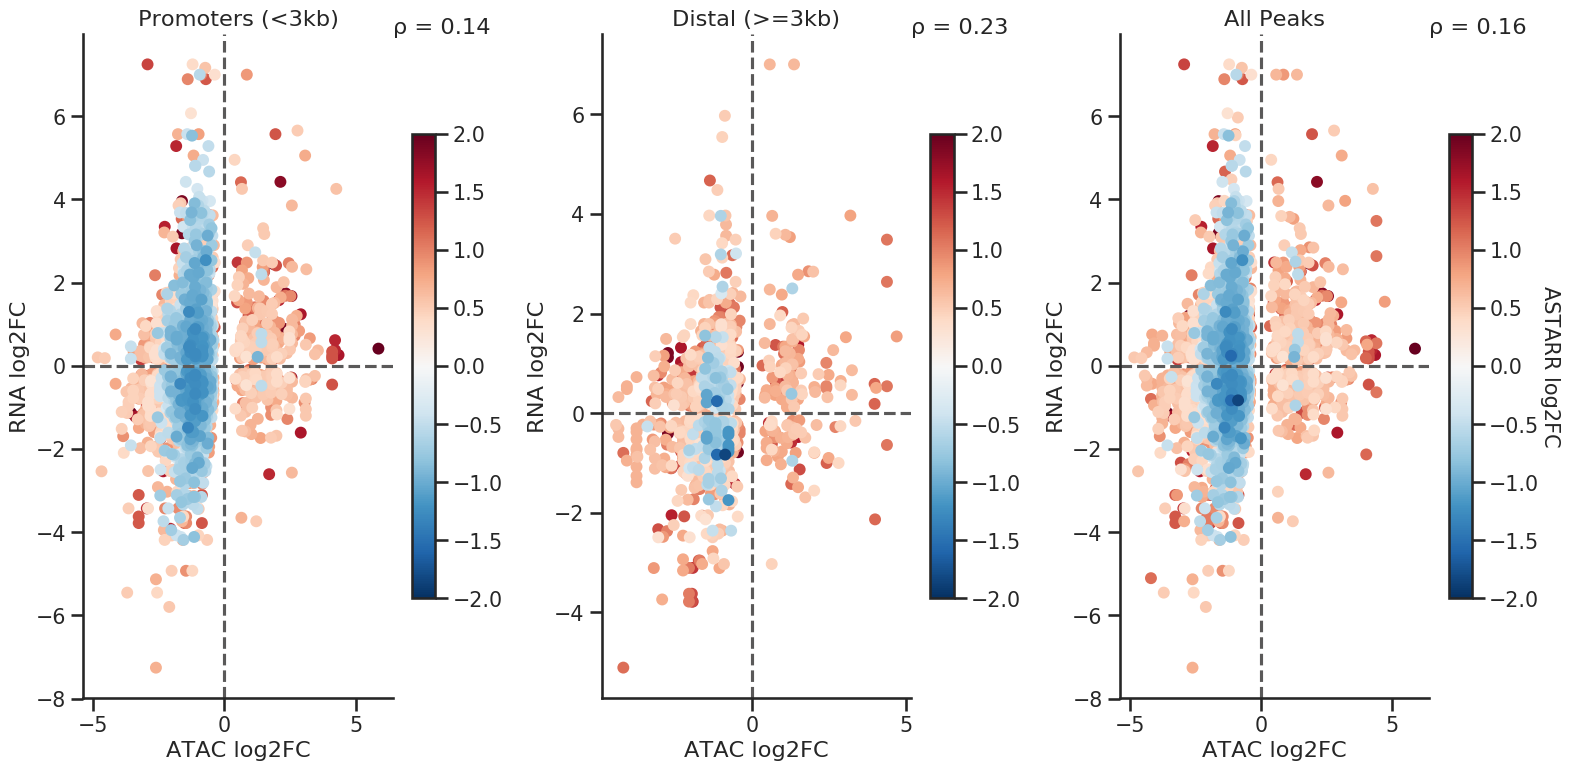

In [65]:
### Scatterplot for promoter(<3kb), distal(>=3kb) and all regions for ATACseq vs ASTARRseq

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns
import numpy as np
%matplotlib inline

from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt 

def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = "\u03C1" # u'\u03C1'
    ax.annotate('%s = %.2f' % (rho, r), xy=(1, 1), xycoords=ax.transAxes)
    
#plt.rcParams['pdf.fonttype'] = 42
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("talk", font_scale=0.9)
plt.rcParams.update({'figure.figsize':(16,8), 'figure.dpi':100})

fig, ax = plt.subplots(1, 3)

ax1 = ax.flatten()[0]
points = ax1.scatter(
    Th2_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.loc[np.abs(Th2_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.distance)<3000, 'ATAC_log2FC'], 
    Th2_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.loc[np.abs(Th2_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.distance)<3000, 'RNA_log2FC'],
    c=Th2_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.loc[np.abs(Th2_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.distance)<3000, 'ASTARR_log2FC'],
    cmap='RdBu_r', marker='o', s=50, label='All hits')

# for x, y, t in zip(
#     Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.loc[np.abs(Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.distance)<3000, 'ATAC_log2FC'],
#     Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.loc[np.abs(Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.distance)<3000, 'RNA_log2FC'], 
#     Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.loc[np.abs(Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.distance)<3000, 'GeneName']) :
#     ax1.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left', textcoords='offset points', fontsize=15)

# ax1.scatter(
#     Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.loc[np.abs(Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.distance)<3000, 'ATAC_log2FC'], 
#     Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.loc[np.abs(Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.distance)<3000, 'RNA_log2FC'],
#     c=Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.loc[np.abs(Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.distance)<3000, 'ASTARR_log2FC'],
#     cmap='RdBu_r', marker='o', s=50)

corrfunc(
    Th2_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.loc[np.abs(Th2_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.distance)<3000, 'ATAC_log2FC'], 
    Th2_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.loc[np.abs(Th2_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.distance)<3000, 'RNA_log2FC'],
    ax=ax1, method='spearman')

ax1.set_xlim(ax1.get_xlim())
ax1.set_ylim(ax1.get_ylim())
ax1.vlines(0, ax1.get_ylim()[0], ax1.get_ylim()[1], color='#5A5959', linestyle='--')
ax1.hlines(0, ax1.get_xlim()[0], ax1.get_xlim()[1], color='#5A5959', linestyle='--')
ax1.set_xlabel('ATAC log2FC')
ax1.set_ylabel('RNA log2FC')
ax1.set_title('Promoters (<3kb)')

cbar = fig.colorbar(points, shrink=0.7, ax=ax1)
#cbar.set_label('ASTARR log2FoldChange', rotation=270, labelpad=15, fontsize=15)
cbar.mappable.set_clim(-2,2)

ax2 = ax.flatten()[1]
points = ax2.scatter(
    Th2_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.loc[np.abs(Th2_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.distance)>=3000, 'ATAC_log2FC'], 
    Th2_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.loc[np.abs(Th2_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.distance)>=3000, 'RNA_log2FC'],
    c=Th2_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.loc[np.abs(Th2_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.distance)>=3000, 'ASTARR_log2FC'],
    cmap='RdBu_r', marker='o', s=50, label='All hits')

# for x, y, t in zip(
#     Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.loc[np.abs(Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.distance)>=3000, 'ATAC_log2FC'],
#     Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.loc[np.abs(Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.distance)>=3000, 'RNA_log2FC'], 
#     Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.loc[np.abs(Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.distance)>=3000, 'GeneName']) :
#     ax2.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left', textcoords='offset points', fontsize=15)
    
# ax2.scatter(
#     Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.loc[np.abs(Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.distance)>=3000, 'ATAC_log2FC'], 
#     Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.loc[np.abs(Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.distance)>=3000, 'RNA_log2FC'],
#     c=Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.loc[np.abs(Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.distance)>=3000, 'ASTARR_log2FC'],
#     cmap='RdBu_r', marker='o', s=50)

corrfunc(
    Th2_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.loc[np.abs(Th2_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.distance)>=3000, 'ATAC_log2FC'], 
    Th2_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.loc[np.abs(Th2_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.distance)>=3000, 'RNA_log2FC'],
    ax=ax2, method='spearman')

ax2.set_xlim(ax2.get_xlim())
ax2.set_ylim(ax2.get_ylim())
ax2.vlines(0, ax2.get_ylim()[0], ax2.get_ylim()[1], color='#5A5959', linestyle='--')
ax2.hlines(0, ax2.get_xlim()[0], ax2.get_xlim()[1], color='#5A5959', linestyle='--')
ax2.set_xlabel('ATAC log2FC')
ax2.set_ylabel('RNA log2FC')
ax2.set_title('Distal (>=3kb)')

cbar = fig.colorbar(points, shrink=0.7, ax=ax2)
#cbar.set_label('ASTARR log2FoldChange', rotation=270, labelpad=15, fontsize=15)
cbar.mappable.set_clim(-2,2)

ax3 = ax.flatten()[2]
points = ax3.scatter(
    Th2_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.loc[:, 'ATAC_log2FC'], 
    Th2_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.loc[:, 'RNA_log2FC'],
    c=Th2_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.loc[:, 'ASTARR_log2FC'],
    cmap='RdBu_r', marker='o', s=50, label='All hits')

# for x, y, t in zip(
#     Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.loc[:, 'ATAC_log2FC'],
#     Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.loc[:, 'RNA_log2FC'], 
#     Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.loc[:, 'GeneName']) :
#     ax3.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left', textcoords='offset points', fontsize=15)
    
# ax3.scatter(
#     Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.loc[:, 'ATAC_log2FC'], 
#     Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.loc[:, 'RNA_log2FC'],
#     c=Th17_ATAC_100kb_RNA_DE_genes_ASTARR_intersected_filtered_with_dist_spGenes.loc[:, 'ASTARR_log2FC'],
#     cmap='RdBu_r', marker='o', s=50)

corrfunc(
    Th2_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.loc[:, 'ATAC_log2FC'], 
    Th2_ATAC_100kb_RNA_DE_genes_ASTARR_intersected.loc[:, 'RNA_log2FC'],
    ax=ax3, method='spearman')

ax3.set_xlim(ax3.get_xlim())
ax3.set_ylim(ax3.get_ylim())
ax3.vlines(0, ax3.get_ylim()[0], ax3.get_ylim()[1], color='#5A5959', linestyle='--')
ax3.hlines(0, ax3.get_xlim()[0], ax3.get_xlim()[1], color='#5A5959', linestyle='--')
ax3.set_xlabel('ATAC log2FC')
ax3.set_ylabel('RNA log2FC')
ax3.set_title('All Peaks')

cbar = fig.colorbar(points, shrink=0.7, ax=ax3)
cbar.set_label('ASTARR log2FC', rotation=270, labelpad=15, fontsize=15)
cbar.mappable.set_clim(-2,2)

sns.despine(fig,ax)
plt.tight_layout()
# plt.savefig('/data/reddylab/Revathy/collabs/Keith/data/integrative/plots/Th17_ATAC_100kb_RNA_DE_genes_ASTARR_distance_filtered_coordinate_plots_without_annotation.pdf')
plt.show()